In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import rasterio
import sys
sys.path.append("..")

In [2]:
from utils import *
from data_reader import *

In [3]:
path_files = "/Users/ninawiedemann/Downloads/tif_ras_buf"

# environmental constraints (resistance)

In [5]:
costs = get_cost_surface(os.path.join(path_files, "corridor"))

read in cost array (1, 1313, 1511)


In [6]:
hard_cons = get_hard_constraints(os.path.join(path_files, "corridor"),os.path.join(path_files, "hard_constraints"))

shape of tif array: (3, 2627, 3022)
(4, 2627, 3022)


### node constraints

In [17]:
costs_rest = (costs*hard_cons.astype(int)) # [:, 500:2000]
costs_rest = reduce_instance(costs_rest, 16)
# todo: ensure sufficient zero padding

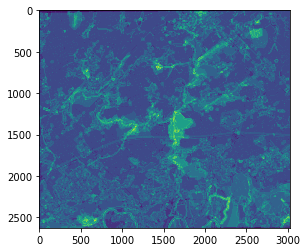

In [138]:
plt.imshow(normalize(costs))
plt.show()

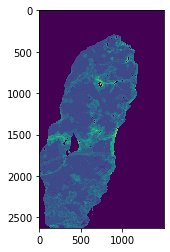

In [47]:
plt.imshow(costs_shifted)
plt.show()

In [12]:
shifts = get_half_donut(15,25)

In [64]:
def get_shift_transformed(shifts):
    
    shift_tuples = []
    for shift in shifts:
        if shift[0]<0:
            tup1 = (0,-shift[0])
        else:
            tup1 = (shift[0],0)
        if shift[1]<0:
            tup2 = (0,-shift[1])
        else:
            tup2 = (shift[1],0)
        shift_tuples.append((tup1,tup2))
    
    return shift_tuples

In [ ]:
x_len, y_len = costs_rest.shape
node_pos = [(i, j) for i in range(x_len) for j in range(y_len) if costs_rest[i, j]]

pos2node = np.ones(costs_rest.shape)
pos2node *= -1
for n, (i,j) in enumerate(node_pos):
    pos2node[i,j] = n

In [132]:
shift_tuples = get_shift_transformed(shifts)

orig_greater_zero = costs_rest>0
inds_orig = pos2node[costs_rest>0]

for i in range(1):
    print(shifts[i], shift_tuples[i])
    a, b, c, d = tuple(slice_tuples[i])
    costs_shifted = np.pad(costs_rest, shift_tuples[i], mode='constant')
    shift = shifts[i]
    if shift[0]>0 and shift[1]>0:
        costs_shifted = costs_shifted[:-shift[0], :-shift[1]]
    elif shift[0]>0 and shift[1]<=0:
        costs_shifted = costs_shifted[:-shift[0], -shift[1]:]
    elif shift[0]<=0 and shift[1]>0:
        costs_shifted = costs_shifted[-shift[0]:, :-shift[1]]
    elif shift[0]<=0 and shift[1]<=0:
        costs_shifted = costs_shifted[-shift[0]:, -shift[1]:]
    
    both_greater_zero = np.all(np.asarray([orig_greater_zero, costs_shifted>0]), axis=0)
    weights = (costs_shifted + costs_rest)/2
    
    inds_shifted = pos2node[costs_shifted>0]
    # delete the ones where inds_shifted is zero
    assert len(inds_shifted)==len(inds_orig)
    weights_list = weights[costs_shifted>0]
    
    pos_inds = inds_shifted>=0
    out = np.swapaxes(np.asarray([inds_orig, inds_shifted, weights_list]), 1,0)[pos_inds]
    print(out.shape)
    print(out[:100])
    # todo: problem with one is zero, other one not
    
    # call add_edge_list 600 times?
    
    plt.figure(figsize=(20,10))
    # plt.imshow((both_greater_zero.astype(int)+orig_greater_zero.astype(int)))
    plt.show()
    print()

(0, 16) ((0, 0), (16, 0))
(1676479, 3)
[[ 30.          46.           7.21999979]
 [ 31.          47.           7.21999979]
 [ 48.          64.           7.21999979]
 [ 49.          65.           7.21999979]
 [ 50.          66.           7.21999979]
 [ 51.          67.           7.21999979]
 [ 52.          68.           7.21999979]
 [ 53.          69.           7.21999979]
 [ 54.          70.           7.21999979]
 [ 55.          71.           7.21999979]
 [ 56.          72.           7.21999979]
 [ 57.          73.           7.21999979]
 [ 74.          90.           7.21999979]
 [ 75.          91.           7.21999979]
 [ 76.          92.           7.21999979]
 [ 77.          93.           7.21999979]
 [ 78.          94.           7.21999979]
 [ 79.          95.           7.21999979]
 [ 80.          96.           7.21999979]
 [ 81.          97.           7.21999979]
 [ 82.          98.           7.21999979]
 [ 83.          99.           7.21999979]
 [ 84.         100.           7.21999

<Figure size 1440x720 with 0 Axes>

In [133]:
(i,j) = node_pos[208]
(k,l) = node_pos[224]
print(i,j,k,l)
print(costs_rest[i,j], costs_rest[k,l])

99 1108 99 1124
7.21999979019165 7.691366672515869


# old stuff

In [ ]:
cuts = []

    for shift in shifts:
        slice_tuple = []
        if shift[0]<0:
            slice_tuple.append(-shift[0])
            slice_tuple.append(None)
        else:
            slice_tuple.append(0)
            slice_tuple.append(-shift[0])
        if shift[1]<0:
            slice_tuple.append(-shift[1])
            slice_tuple.append(None)
        else: 
            slice_tuple.append(0)
            slice_tuple.append(-shift[1])
        cuts.append(slice_tuple)
    

### Open questions:

* How to combine different costs? simply add up the absolute values? Or normalize to 0-1 and weight?

### Possible constraints:

* Height of tower --> make six nodes instead of one, connect for each possible combination of heights
* Height of cables above ground
* Angles
* cables passing over environmental


### Todo:

* write possibility to split one surface into several parts and merge the paths in the end

In [81]:
arr = np.zeros((10,10))
arr[3:5,4:7]=1

In [82]:
np.where(arr>0)

(array([3, 3, 3, 4, 4, 4]), array([4, 5, 6, 4, 5, 6]))

In [83]:
new_arr = np.zeros((10,10))
new_arr[np.where(arr>0)]=1

In [84]:
new_arr

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Random tests

In [110]:
arr2 = np.zeros((5,5))
arr2[2:5, 1:3]=1

In [108]:
counter=0
for i in range(5):
    for j in range(5):
        arr[i,j] = counter
        counter+=1

In [112]:
arr

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.]])

In [113]:
arr[arr2.astype(bool)]

array([11., 12., 16., 17., 21., 22.])

In [114]:
arr2

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.]])